In [1]:
%matplotlib inline
from decimal import Decimal
import itertools
from pprint import pprint

import common

from matplotlib import pyplot as plt
import matplotlib

In [17]:
import random
import numpy

def die(i):
    if random.random() > common.lifetable_for_women[i]:
        return die(i+1)
    else:
        return i

def gen_age():
    return die(0) + 65

from common import vpw_rates, ssr, cew, wer

def vpw_wer(us):
    lifespan = gen_age() - 65
    
    if lifespan == 0:
        return vpw_rates[0] / 1

    returns = [us.random_year() for n in range(lifespan)]
    p = [y.stocks / 5 * 3 + y.bonds / 5 * 2 for y in returns]
    r = vpw_rates[0:lifespan]

    return wer(r, p)

def const_pct_wer(us, constant=Decimal('.055')):
    lifespan = gen_age() - 65

    # Ugly hack to handle this edge case.... :(
    if lifespan == 0:
        return constant / 1
        
    returns = [us.random_year() for n in range(lifespan)]
    p = [y.stocks / 5 * 3 + y.bonds / 5 * 2 for y in returns]
    r = list(itertools.repeat(constant, lifespan))
    
    return wer(r, p)

def em_wer(us):
    # generate returns for the final year of their life...
    # even though they don't live to the end of it.
    # TODO: check the EM 'terminates' when the retiree does
    # and doesn't run an extra year
    lifespan = gen_age() - 65
    p = []
    
    def make_withdrawals():
        years_left = 40
        portfolio = 1000000
        
        em = common.EM.calc_withdrawal(portfolio, years_left)
        wd = em.send(None)
        yield wd / portfolio
        
        for i in range(lifespan):
            portfolio -= wd
            year = us.random_year()
            gains = year.stocks * Decimal('.6') + year.bonds * Decimal('.4')
            p.append(gains)
            portfolio *= (1 + gains)
            wd = em.send((portfolio, year.inflation))
            yield wd / portfolio

    r = list(make_withdrawals())

    return wer(r, p)

def calc_wer(n, fn_wer):
    us = common.Returns_US_1871()
    w = []
    for i in range(n):
        w.append(fn_wer(us))
    return numpy.average([float(n) for n in w])

print(calc_wer(25, vpw_wer))
print(calc_wer(25, const_pct_wer))
print(calc_wer(25, em_wer))

0.571659602094
0.577267796289
0.542487254394


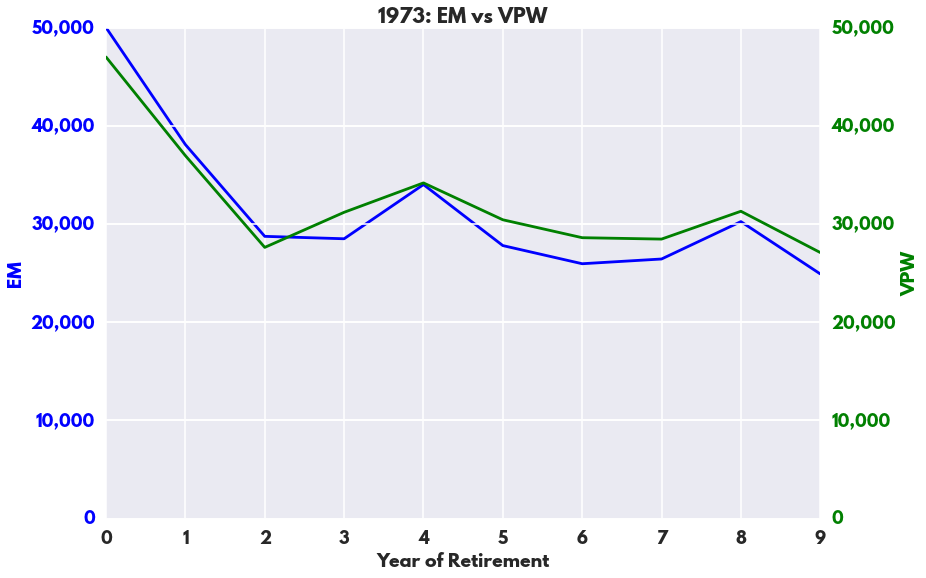

In [3]:
import math
from common import simulate_withdrawals, plot_two

def compare_em_vs_vpw(series, years=40, title=''):
    (r1, r2) = itertools.tee(series)
    x = simulate_withdrawals(r1, years=years)
    y = simulate_withdrawals(r2, years=years, withdraw=common.VPW)

    s1 = [n.withdraw_r for n in x]
    s2 = [n.withdraw_r for n in y]
    
    ceiling = max(max(s1), max(s2))
    if ceiling < 100000:
        ceiling = int(math.ceil(ceiling / 10000) * 10000)
    else:
        ceiling = int(math.ceil(ceiling / 100000) * 100000)
    
    plot_two(s1, s2, s1_title='EM', s2_title='VPW',
                       y_lim=[0,ceiling],
                       x_label='Year of Retirement', title=title)

def em_vs_vpw(year, years=40):
    compare_em_vs_vpw(common.Returns_US_1871().iter_from(year), title='%d: EM vs VPW' % year, years=years)

em_vs_vpw(1973, years=10)

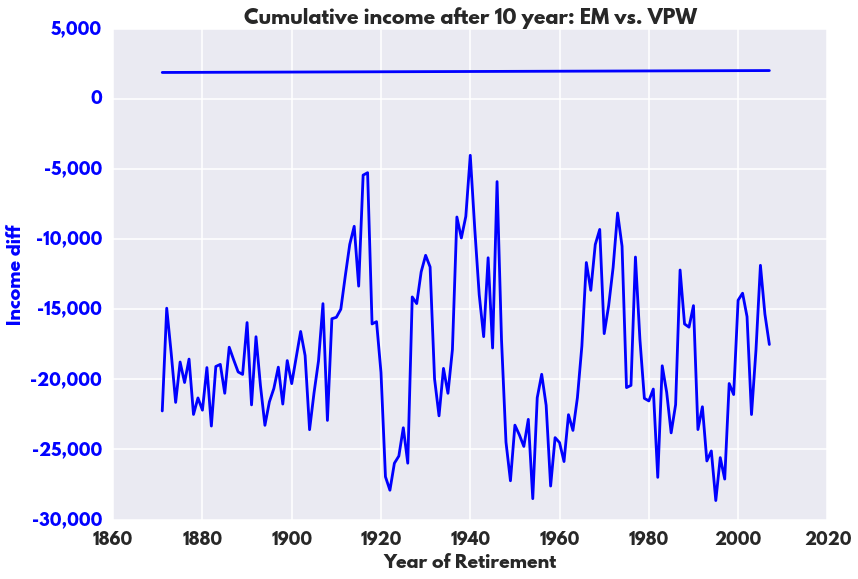

In [4]:
data_series = common.Returns_US_1871()

income_diff = []

YEARS = 10
for i in range(data_series.years_of_data):
    year = i + 1871

    (s1, s2) = itertools.tee(data_series.iter_from(year))
    x = common.simulate_withdrawals(s1, years=YEARS)
    y = common.simulate_withdrawals(s2, years=YEARS, withdraw=common.VPW)

    # skip incomplete retirements
    if len(x) < YEARS:
        continue

    em_income = sum([n.withdraw_r for n in x])
    vpw_income = sum([n.withdraw_r for n in y])
    income_diff.append((em_income - vpw_income, year))

x_values = range(1871, 1871 + len(income_diff))

#ylim = [-100000, 50000]

#pprint(sorted(income_diff))

fig, ax1 = plt.subplots()
common.format_axis_labels_with_commas(ax1.get_yaxis())
ax1.plot(x_values, income_diff, 'b')
#ax1.set_ylim(ylim)
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax1.set_ylabel('Income diff', color='b')
ax1.set_xlabel('Year of Retirement')

#ax2 = ax1.twinx()
#common.format_axis_labels_with_commas(ax2.get_yaxis())
#ax2.plot(x_values, portfolio_diff, 'g')
#ax2.set_ylim(ylim)
#for tl in ax2.get_yticklabels():
#    tl.set_color('g')
#ax2.set_ylabel('Portfolio diff', color='g')

plt.title('Cumulative income after %d year: EM vs. VPW' % YEARS)

plt.show()

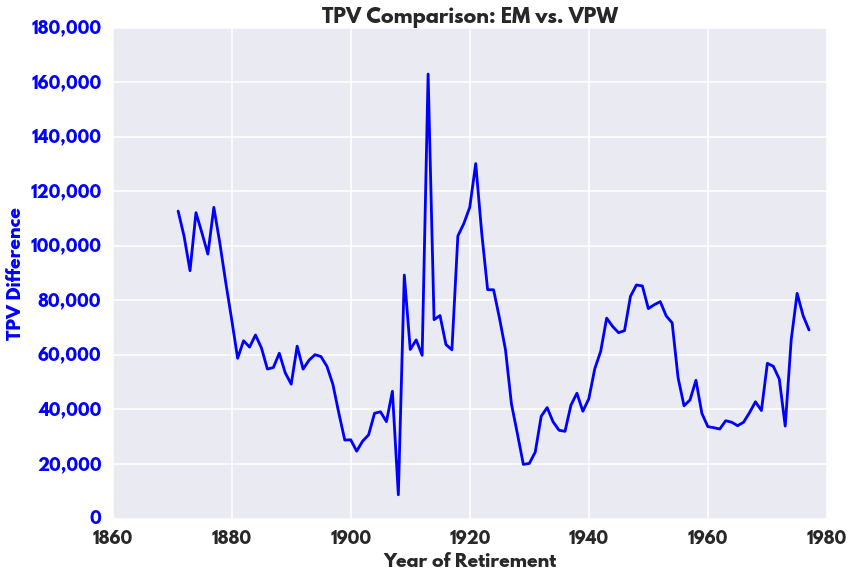

In [5]:
data_series = common.Returns_US_1871()

tpv_diff = []
YEARS = 40
for i in range(data_series.years_of_data):
    year = i + 1871

    (s1, s2) = itertools.tee(data_series.iter_from(year))
    x = common.simulate_withdrawals(s1, years=YEARS)
    y = common.simulate_withdrawals(s2, years=YEARS, withdraw=common.VPW)

    # skip incomplete retirements
    if len(x) < 40:
        continue

    tpv_diff.append(x[20].portfolio_r - y[20].portfolio_r)

x_values = range(1871, 1871 + len(tpv_diff))

fig, ax1 = plt.subplots()
common.format_axis_labels_with_commas(ax1.get_yaxis())
ax1.plot(x_values, tpv_diff, 'b')
#ax1.set_ylim(ylim)
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax1.set_ylabel('TPV Difference', color='b')
ax1.set_xlabel('Year of Retirement')

#ax2 = ax1.twinx()
#common.format_axis_labels_with_commas(ax2.get_yaxis())
#ax2.plot(x_values, portfolio_diff, 'g')
#ax2.set_ylim(ylim)
#for tl in ax2.get_yticklabels():
#    tl.set_color('g')
#ax2.set_ylabel('Portfolio diff', color='g')

plt.title('TPV Comparison: EM vs. VPW')

plt.show()